In [1]:
# sci-kit image documentation: 
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_haar_extraction_selection_classification.html
import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

# for loading and preprocessing images
import pandas as pd
from PIL import Image
import pathlib

In [2]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [3]:
def err(Y1, Y2):
    return np.mean(Y1!=Y2)

In [4]:
# loading data
DATA_DIR = "facial_expressions/data"
IMAGE_DIR = "facial_expressions/images"
data = pd.read_csv(f'{DATA_DIR}/legend.csv')
data['emotion'] = data['emotion'].str.lower()
# prepping datasets
X_temp = []
# ran into too many files open error: https://stackoverflow.com/questions/29234413/too-many-open-files-error-when-opening-and-loading-images-in-pillow
# find the minimum width and height and I can resize all images to that shape
min_width = 1000
min_height = 1000
for image in data['image']:
    temp = Image.open(IMAGE_DIR + '/' + image)
    keep = temp.copy().convert('L')
    min_width = min(min_width, keep.size[0])
    min_height = min(min_height, keep.size[1])
    X_temp.append(keep)
    temp.close()
images = np.array([np.asarray(image.resize((min_width, min_height))) for image in X_temp])

In [5]:
# training
# all feature types
feature_types = ['type-2-x', 'type-2-y']
# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)

# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_full_feature_comp = time() - t_start

# Label images with emotion
Y = np.array(data['emotion'])

# spliting data in to training and validation sets
split_factor = 0.8
stop = int(split_factor * len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=stop,
                                                    random_state=0,
                                                    stratify=Y)

# Extract all possible features
feature_coord, feature_type = haar_like_feature_coord(width=images.shape[2],height=images.shape[1],feature_type=feature_types)

# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, Y_train)
time_full_train = time() - t_start


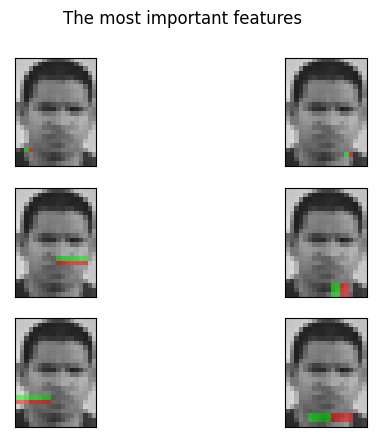

In [6]:
Y_predict = clf.predict(X_test)
accuracy_rate = 1 - err(Y_predict, Y_test)
training_error = err(clf.predict(X_train),Y_train)
testing_error = err(clf.predict(X_test),Y_test)

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')
plt.show()

In [7]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.')

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_subs_feature_comp = time() - t_start

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=stop,
                                                    random_state=0,
                                                    stratify=Y)

21512 features, or 44.0%, account for 70% of branch points in the random forest.


In [8]:
t_start = time()
clf.fit(X_train, Y_train)
time_subs_train = time() - t_start

Y_predict = clf.predict(X_test)
sub_accuracy_rate = 1 - err(Y_predict, Y_test)
sub_training_error = err(clf.predict(X_train),Y_train)
sub_testing_error = err(clf.predict(X_test),Y_test)

In [12]:
summary = ( f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training '
            f'with an accuracy rate of {accuracy_rate:.2f}, '
            f'training error of {training_error:.2f}, '
            f'and testing error of {testing_error:.2f}. '
            f'Computing the restricted feature set took '
            f'{time_subs_feature_comp:.3f}s, plus {time_subs_train:.3f}s training '
            f'with an accuracy rate of {sub_accuracy_rate:.2f} '
            f'training error of {sub_training_error:.2f}, '
            f'and testing error of {sub_testing_error:.2f}. '
          )
print(summary)
plt.show()

Computing the full feature set took 559.624s, plus 89.283s training with an accuracy rate of 0.76, training error of 0.00, and testing error of 0.24. Computing the restricted feature set took 102.441s, plus 152.941s training with an accuracy rate of 0.76 training error of 0.00, and testing error of 0.24. 
